# <center>Bank Marketing Promotional Strategy</center> 

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [3]:
import os 
os.chdir('/content/drive/My Drive/Analytics Vidhya/HackLive1')

In [4]:
!ls

SampleSubmission_XkIpo3X.csv  Test_jPKyvmK.csv	Train_eP48B9k.csv


In [5]:
train = pd.read_csv('Train_eP48B9k.csv')
test = pd.read_csv('Test_jPKyvmK.csv')
ss = pd.read_csv('SampleSubmission_XkIpo3X.csv')

## 1. Dataset Contents


In [6]:
train.head(3)
test.head(3)

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0


,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome
0,id_17231,55.0,retired,married,tertiary,no,7136.0,no,no,cellular,13,aug,90.0,2.0,NaN,0,unknown
1,id_34508,24.0,blue-collar,single,secondary,no,179.0,yes,no,cellular,18,may,63.0,2.0,NaN,0,unknown
2,id_44504,46.0,technician,divorced,secondary,no,143.0,no,no,cellular,8,jul,208.0,1.0,NaN,0,unknown


In [8]:
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'

## 1. Shape of Dataset(Variables & Observations)


In [9]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 31647 samples and 18 variables

Test contains 13564 samples and 17 variables

The dataset contains 16 features


##3. Target Distribution

In [12]:
train[TARGET_COL].value_counts(normalize=True)

0    0.892754
1    0.107246
Name: term_deposit_subscribed, dtype: float64

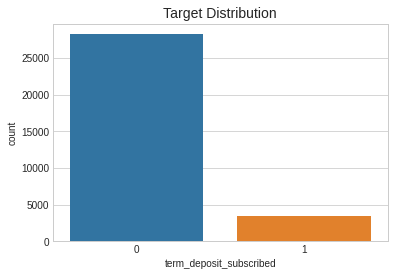

In [13]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

## 4. Variable Datatypes

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

## 5. Unique Values

In [17]:
train.nunique()

id                                  31647
customer_age                        77   
job_type                            12   
marital                             3    
education                           4    
default                             2    
balance                             6563 
housing_loan                        2    
personal_loan                       2    
communication_type                  3    
day_of_month                        31   
month                               12   
last_contact_duration               1447 
num_contacts_in_campaign            46   
days_since_prev_campaign_contact    511  
num_contacts_prev_campaign          41   
prev_campaign_outcome               4    
term_deposit_subscribed             2    
dtype: int64

##6. Null Values

In [26]:
null_values_per_variable = 100*(train.isnull().sum()/len(train)).round(3)
null_values_per_variable.sort_values(ascending=False)

days_since_prev_campaign_contact    81.6
customer_age                        2.0 
balance                             1.3 
last_contact_duration               1.0 
personal_loan                       0.5 
marital                             0.5 
num_contacts_in_campaign            0.4 
job_type                            0.0 
education                           0.0 
default                             0.0 
term_deposit_subscribed             0.0 
housing_loan                        0.0 
prev_campaign_outcome               0.0 
communication_type                  0.0 
day_of_month                        0.0 
month                               0.0 
num_contacts_prev_campaign          0.0 
id                                  0.0 
dtype: float64

## Columns 



In [27]:
train.columns

Index(['id', 'customer_age', 'job_type', 'marital', 'education', 'default',
       'balance', 'housing_loan', 'personal_loan', 'communication_type',
       'day_of_month', 'month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'prev_campaign_outcome',
       'term_deposit_subscribed'],
      dtype='object')

## Segregating Categorical and Numerical Features 

**1. Categorical Variables** 

In [35]:
categorical = train.select_dtypes(include=['object'])


In [36]:
cat_cols = [c for c in features if c in categorical]
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

**2. Numerical Features**

In [37]:
num_cols = [n for n in features if n not in cat_cols]
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

## **Exploratory Data Analysis**

**1. Univariate Analysis :** 

**Pie Charts** 


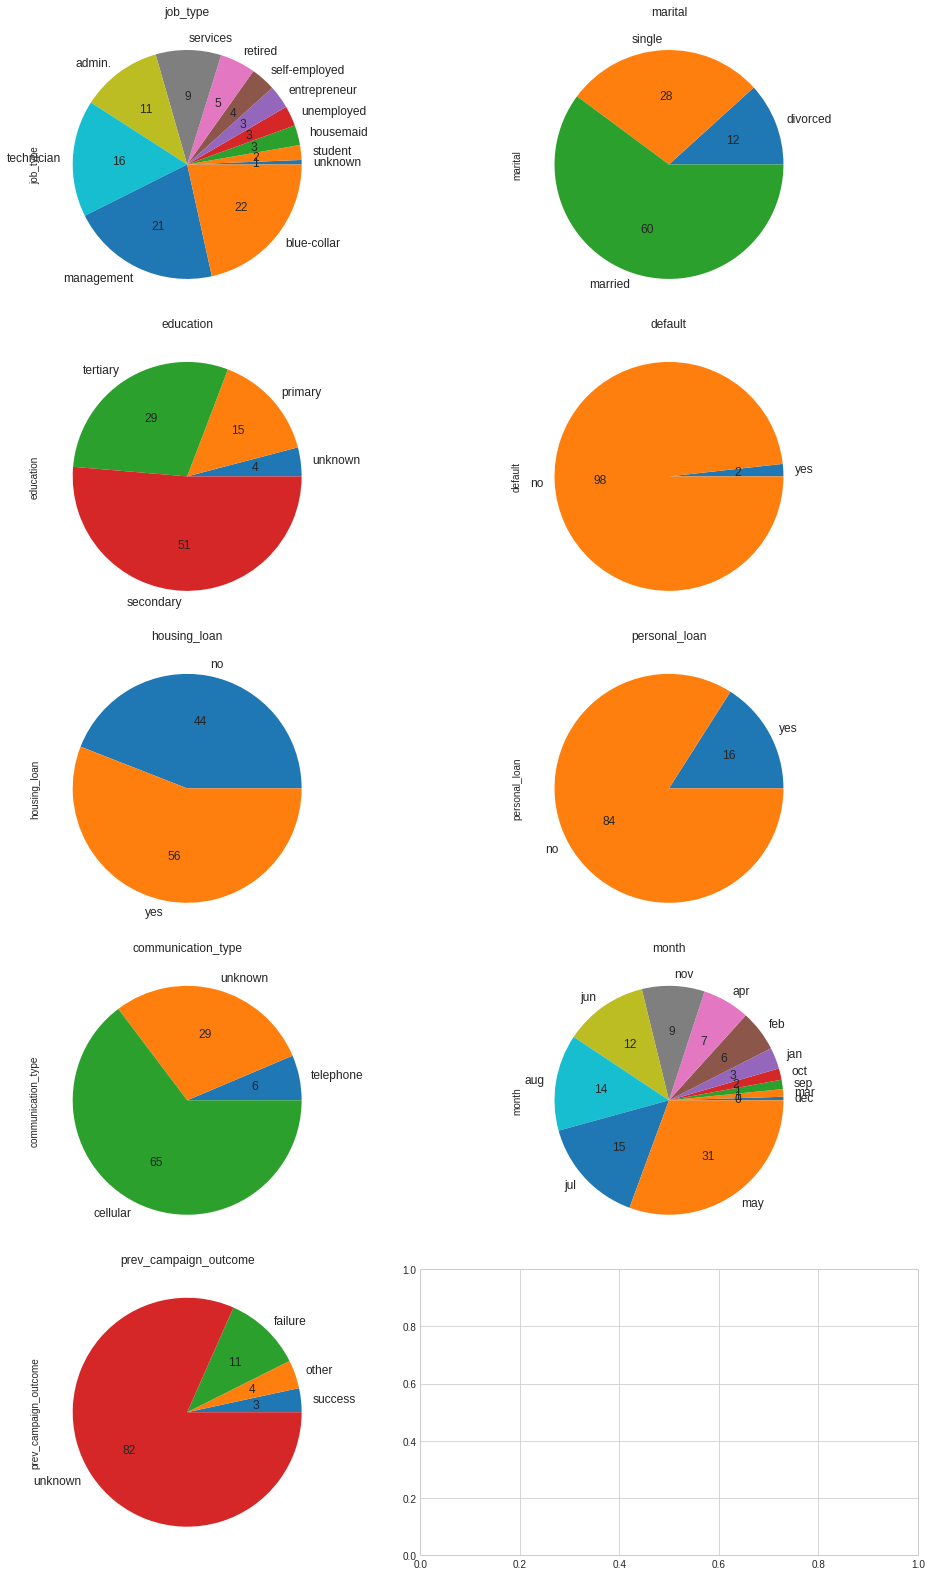

In [43]:
fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[cat_cols]):
  _ = train[c].value_counts()[::-1].plot(kind='pie', ax=axes[i], title=c, autopct="%.0f", fontsize=12)
  _ = axes[i].set_label('')
_ = plt.tight_layout()

**Bar Graphs**

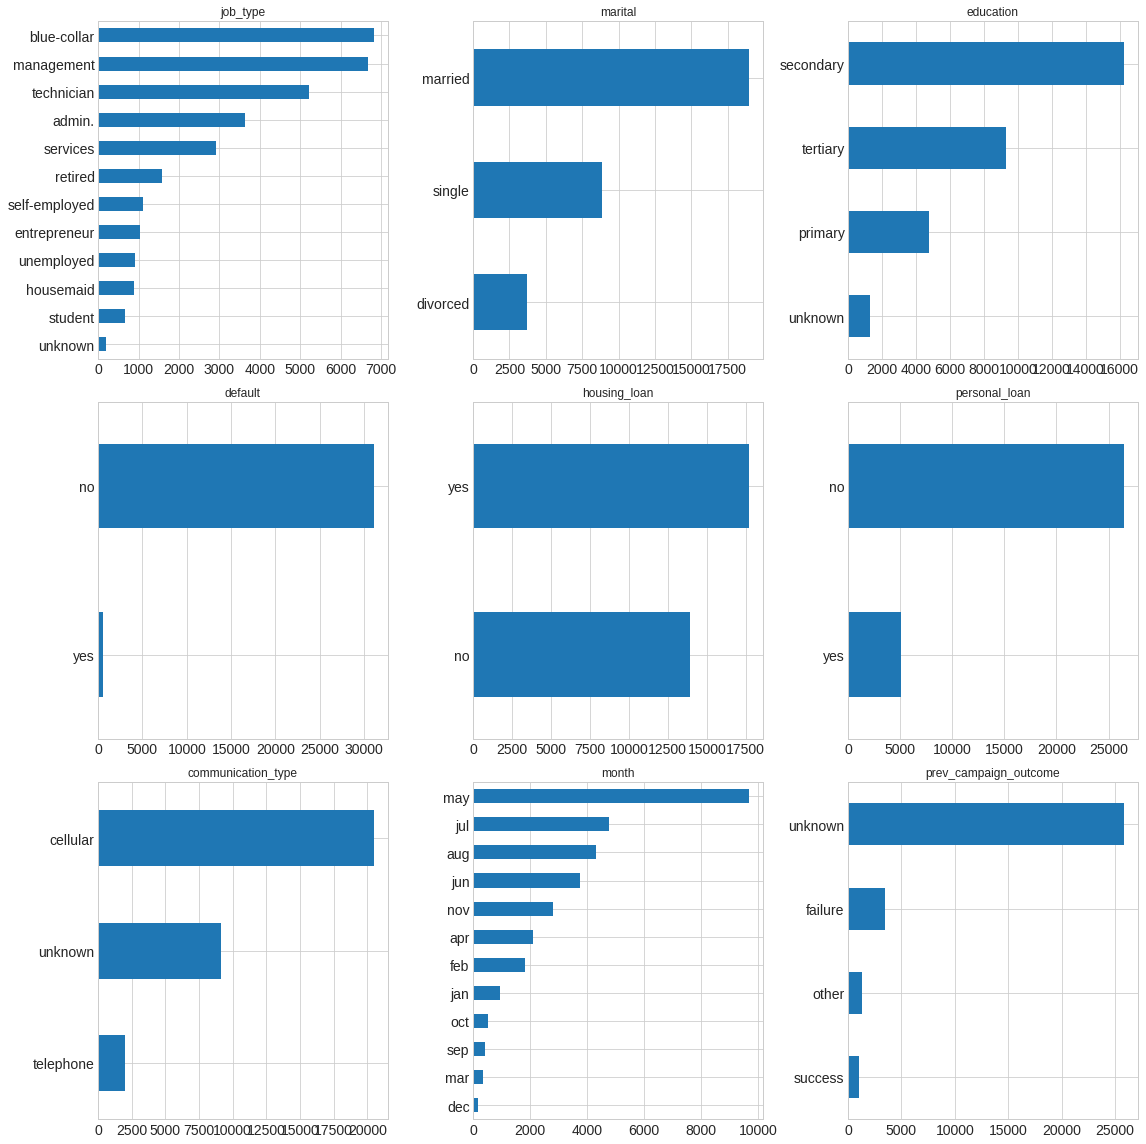

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

## **2. Bivariate Analysis**

**Relationship Between two Variabels**

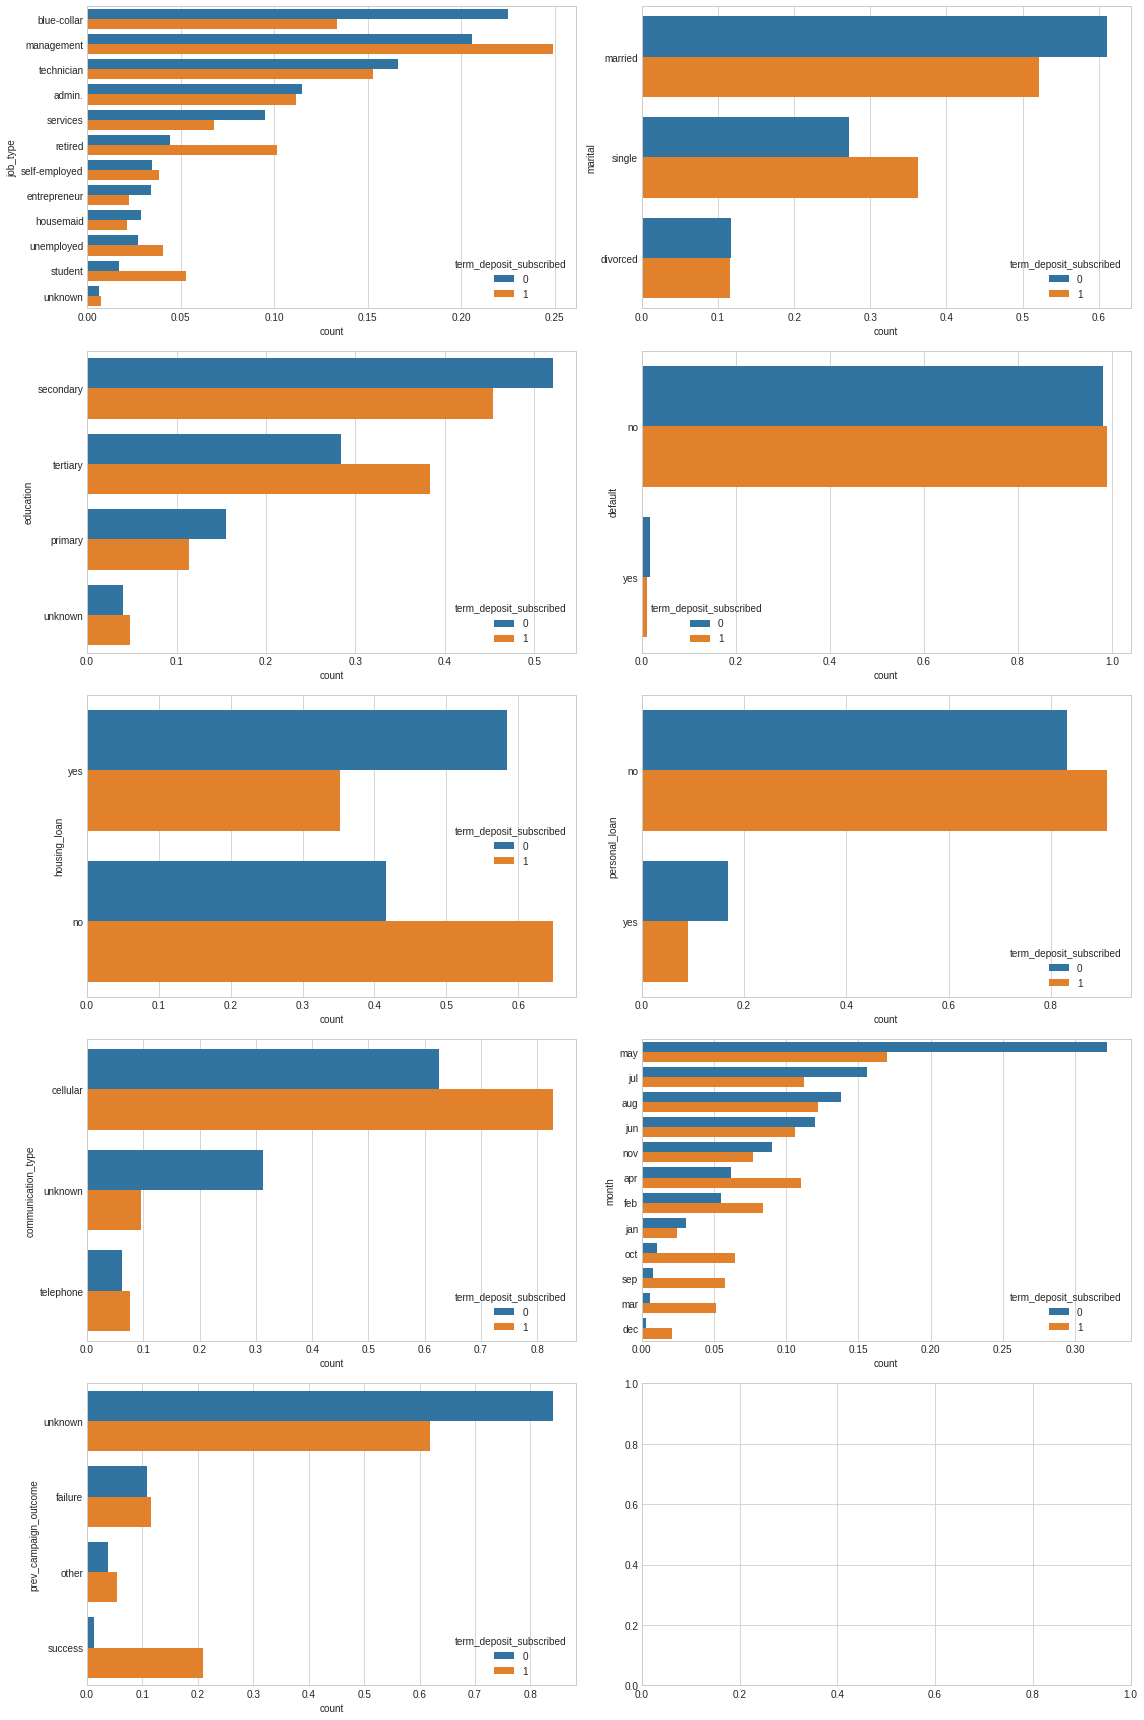

In [45]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

## **Numerical Features**

## **1. Univariate Analysis**

**Boxplots**


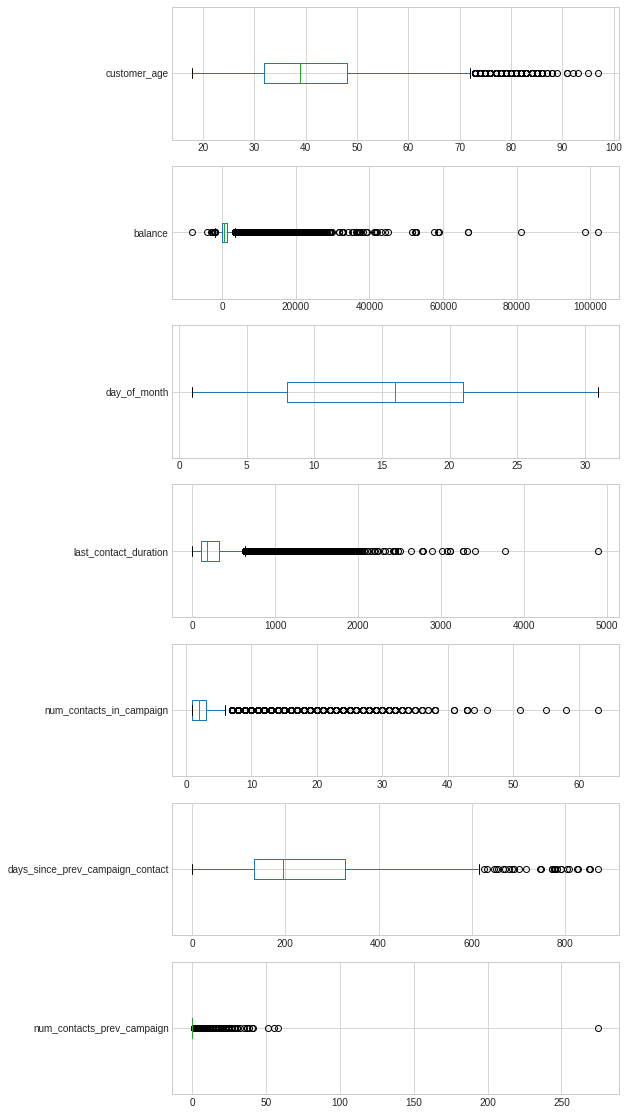

In [49]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

**Density Plots**

In [52]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

##**2. Bivariate Analysis**

**KDE Plots**

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
plt.tight_layout()

**Bar Plots**

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

# **Model Building** 

In [53]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(45211, 18)

In [54]:
df = pd.get_dummies(df, columns= cat_cols)

In [55]:
df.head()

,id,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,term_deposit_subscribed,job_type_admin.,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,job_type_unemployed,job_type_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_loan_no,housing_loan_yes,personal_loan_no,personal_loan_yes,communication_type_cellular,communication_type_telephone,communication_type_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown
0,id_43823,28.0,285.0,26,303.0,4.0,NaN,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,id_32289,34.0,934.0,18,143.0,2.0,132.0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,id_10523,46.0,656.0,5,101.0,4.0,NaN,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,id_43951,34.0,2.0,20,127.0,3.0,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,id_40992,41.0,1352.0,13,49.0,2.0,NaN,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [56]:
df = df.fillna(0)
df.isnull().sum().sum()

0

In [57]:
# Splitting
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [58]:
len(features)

51

In [59]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

### Logistic Regression Model 


In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [61]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.4821763602251407

Downloading Submission file


In [63]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [64]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_logistic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Decision Tree

In [65]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.48845867460908415

In [66]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_decision_tree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Hyper Parameter Tuning 
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128,256],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 20}

In [69]:
optimal_params = {'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 20}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.6030085022890779

In [70]:
preds_test = clf.predict(X_test)

download_preds(preds_test, file_name = 'hacklive_dt_tuned_random.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## K-FOLD Validation

In [71]:
from sklearn.model_selection import StratifiedKFold

In [72]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

In [73]:
target = train[TARGET_COL]

In [75]:
dt_params = {'class_weight': {0: 1, 1: 2},
             'criterion': 'gini',
             'max_depth': 14,
             'max_features': 0.8,
             'max_leaf_nodes': 128,
             'min_samples_split': 20,
             'random_state': 1
             }

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.6226975638740345

------------- Fold 2 -------------

F1 score for validation set is 0.6232670283303194

------------- Fold 3 -------------

F1 score for validation set is 0.5957446808510639

------------- Fold 4 -------------

F1 score for validation set is 0.6082089552238805

------------- Fold 5 -------------

F1 score for validation set is 0.609167671893848


F1 score for oofs is 0.6121794871794872


In [76]:
dt_preds_rounded = dt_preds.round()
download_preds(dt_preds_rounded, file_name = 'hacklive_dt_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## LightGBM

In [77]:
from lightgbm import LGBMClassifier

In [78]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.5788197251414712

------------- Fold 2 -------------

F1 score for validation set is 0.6059152677857714

------------- Fold 3 -------------

F1 score for validation set is 0.5690923957481603

------------- Fold 4 -------------

F1 score for validation set is 0.5871857258718572

------------- Fold 5 -------------

F1 score for validation set is 0.5621445978878961


F1 score for oofs is 0.5807287449392713


In [79]:
lgb_preds_rounded = lgb_preds.round()
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Threshold Optimization

In [80]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.19371593276447588
Threshold 0.01: 0.40458973286320443
Threshold 0.02: 0.4821517991272623
Threshold 0.03: 0.5222473310995092
Threshold 0.04: 0.5458565345561742
Threshold 0.05: 0.5650468883205456
Threshold 0.06: 0.5784717957715589
Threshold 0.07: 0.5892183288409704
Threshold 0.08: 0.5988222304011778
Threshold 0.09: 0.6062370843509299
Threshold 0.1: 0.6124557543289008
Threshold 0.11: 0.6170461179217747
Threshold 0.12: 0.620778194746198
Threshold 0.13: 0.6268057784911717
Threshold 0.14: 0.6309039087947882
Threshold 0.15: 0.6323711340206186
Threshold 0.16: 0.6343962362780973
Threshold 0.17: 0.6369224247562526
Threshold 0.18: 0.6394411606663085
Threshold 0.19: 0.6426165380854069
Threshold 0.2: 0.6432581177765547
Threshold 0.21: 0.6444692737430168
Threshold 0.22: 0.6446056210335448
Threshold 0.23: 0.6471868912570184
Threshold 0.24: 0.6490496059341678
Threshold 0.25: 0.6511627906976745
Threshold 0.26: 0.6522513959843174
Threshold 0.27: 0.6509060362414497
Threshold 0.28: 0.6517

In [81]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.26


0.6522513959843174

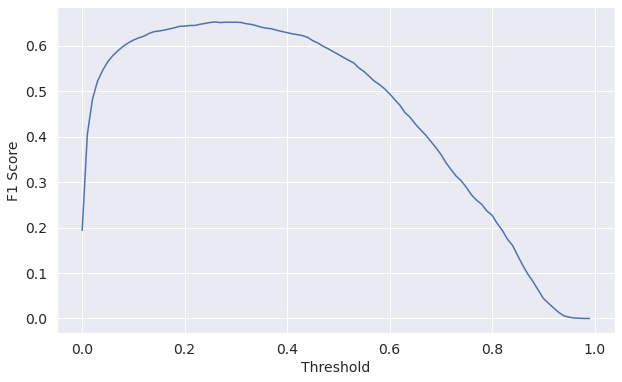

In [82]:
optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
f1_score(target, (lgb_oofs > optimal_thresh) * 1)

In [83]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_threshold_optimized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tuned LGBM

In [142]:
del train['days_since_prev_campaign_contact']

In [151]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.211833
[200]	valid_0's binary_logloss: 0.181337
[300]	valid_0's binary_logloss: 0.169162
[400]	valid_0's binary_logloss: 0.164541
[500]	valid_0's binary_logloss: 0.16226
[600]	valid_0's binary_logloss: 0.161485
[700]	valid_0's binary_logloss: 0.161343
[800]	valid_0's binary_logloss: 0.161432
Early stopping, best iteration is:
[715]	valid_0's binary_logloss: 0.161323

F1 score for validation set is 0.5953338696701529

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.209917
[200]	valid_0's binary_logloss: 0.179486
[300]	valid_0's binary_logloss: 0.167387
[400]	valid_0's binary_logloss: 0.162388
[500]	valid_0's binary_logloss: 0.159905
[600]	valid_0's binary_logloss: 0.15886
[700]	valid_0's binary_logloss: 0.158282
[800]	valid_0's binary_logloss: 0.158124
[900]	valid_0's binar

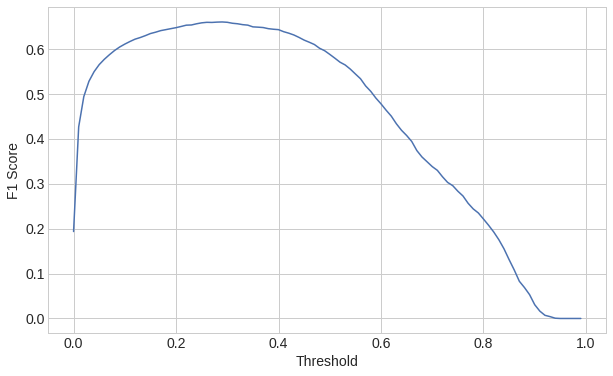

In [166]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

## Final Submission


In [167]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_hyperparameter_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>